<a href="https://www.kaggle.com/code/sonyalawrence/russian-invasion-of-ukraine?scriptVersionId=93389285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Assessment of damage associated with Russia's invasion of Ukraine

##### Download all libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display
from PIL import Image
import urllib.request
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import log10, floor

print(plt.style.available)
mpl.style.use(['ggplot'])

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Read the CSV file into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

### Let's start by getting a basic understanding of the DataFrame and cleaning the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200
5,2022-03-02,7,5840,about,200
6,2022-03-03,8,9000,about,200
7,2022-03-04,9,9166,about,200
8,2022-03-05,10,10000,about,216
9,2022-03-06,11,11000,about,232


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)
russian_personnel.info()
russian_personnel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 2022-02-25 to 2022-04-18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     53 non-null     int64
 1   POW     53 non-null     int64
dtypes: int64(2)
memory usage: 1.2+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
0,2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,NaN,NaN
5,2022-03-02,7,30,31,211,862,85,40,355,60,3,2,9,NaN,NaN
6,2022-03-03,8,30,31,217,900,90,42,374,60,3,2,11,NaN,NaN
7,2022-03-04,9,33,37,251,939,105,50,404,60,3,2,18,NaN,NaN
8,2022-03-05,10,39,40,269,945,105,50,409,60,3,2,19,NaN,NaN
9,2022-03-06,11,44,48,285,985,109,50,447,60,4,2,21,NaN,NaN


In [6]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment = russian_equipment.fillna(0)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()
russian_equipment.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 2022-02-25 to 2022-04-18
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day                    53 non-null     int64  
 1   aircraft               53 non-null     int64  
 2   helicopter             53 non-null     int64  
 3   tank                   53 non-null     int64  
 4   APC                    53 non-null     int64  
 5   field artillery        53 non-null     int64  
 6   MRL                    53 non-null     int64  
 7   military auto          53 non-null     int64  
 8   fuel tank              53 non-null     int64  
 9   drone                  53 non-null     int64  
 10  naval ship             53 non-null     int64  
 11  anti-aircraft warfare  53 non-null     int64  
 12  special equipment      53 non-null     float64
 13  mobile SRBM system     53 non-null     float64
dtypes: float64(2), int64(12)
memory usage: 6.2+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system
date,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,100,60,0,2,0,0.0,0.0
2022-02-26,3,27,26,146,706,49,4,130,60,2,2,0,0.0,0.0
2022-02-27,4,27,26,150,706,50,4,130,60,2,2,0,0.0,0.0
2022-02-28,5,29,29,150,816,74,21,291,60,3,2,5,0.0,0.0
2022-03-01,6,29,29,198,846,77,24,305,60,3,2,7,0.0,0.0


In [7]:
#Change all numberic data to integer.
russian_equipment = russian_equipment.astype({'special equipment':np.int64, 'mobile SRBM system':np.int64})
russian_equipment.info()


<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 2022-02-25 to 2022-04-18
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   day                    53 non-null     int64
 1   aircraft               53 non-null     int64
 2   helicopter             53 non-null     int64
 3   tank                   53 non-null     int64
 4   APC                    53 non-null     int64
 5   field artillery        53 non-null     int64
 6   MRL                    53 non-null     int64
 7   military auto          53 non-null     int64
 8   fuel tank              53 non-null     int64
 9   drone                  53 non-null     int64
 10  naval ship             53 non-null     int64
 11  anti-aircraft warfare  53 non-null     int64
 12  special equipment      53 non-null     int64
 13  mobile SRBM system     53 non-null     int64
dtypes: int64(14)
memory usage: 6.2+ KB


### Problem 1
##### Visually represent where the invasion is happening.

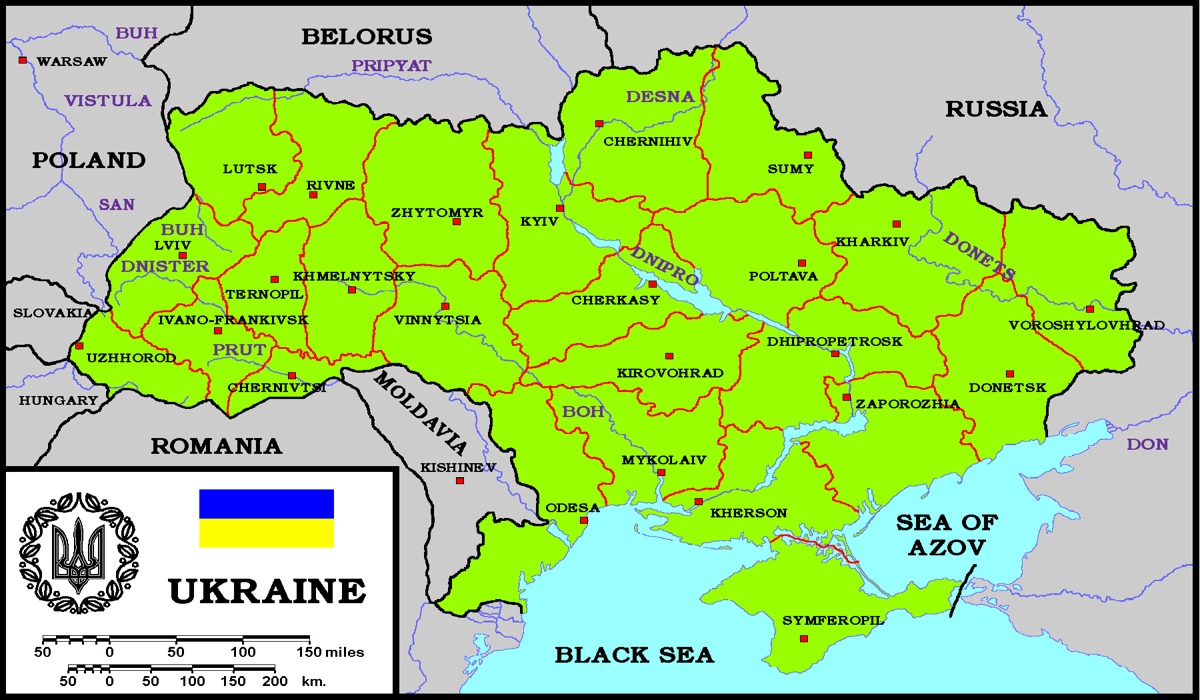

In [8]:
# Downloading data
urllib.request.urlretrieve("http://www.vidiani.com/maps/maps_of_europe/maps_of_ukraine/detailed_political_and_administrative_map_of_ukraine.jpg", 
                           "ukraine_map.jpg")

# Read image
img = Image.open('ukraine_map.jpg').resize((1200, 700))

# Display Image specs
display(img)

### Problem 2

##### Show the total Prisoners of War per day recorded in the Personel table.


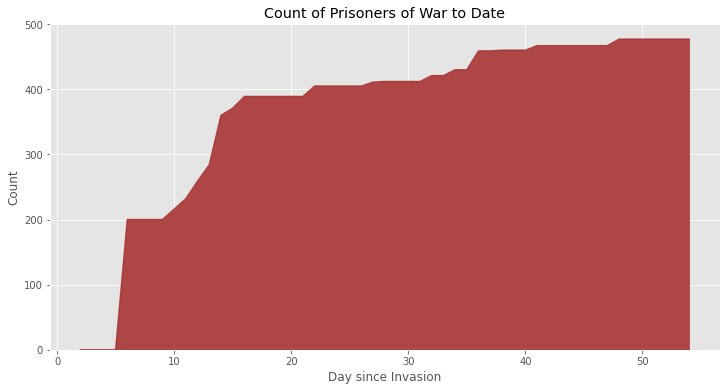

In [9]:
pow_data = russian_personnel[["day", "POW"]]
pow_data.reset_index('date', inplace=True)
pow_data.plot(kind='area', x='day', y='POW', color='brown', alpha = .85, figsize=(12,6), legend=False)
plt.title('Count of Prisoners of War to Date')
plt.xlabel('Day since Invasion')
plt.ylabel('Count') 
plt.show()

### Problem 3
##### Visualize the daily change in number of POW and Total POW.

In [10]:
last = 0
increase = []

for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
pow_data['Daily_Increase_in_Prisoners_of_War'] = increase

pow_data_ = pow_data[['day', 'POW', 'Daily_Increase_in_Prisoners_of_War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily_Total_Prisoners_of_War'}, inplace=True)
pow_data_

,Daily_Total_Prisoners_of_War,Daily_Increase_in_Prisoners_of_War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
7,200,0
8,200,0
9,200,0
10,216,16


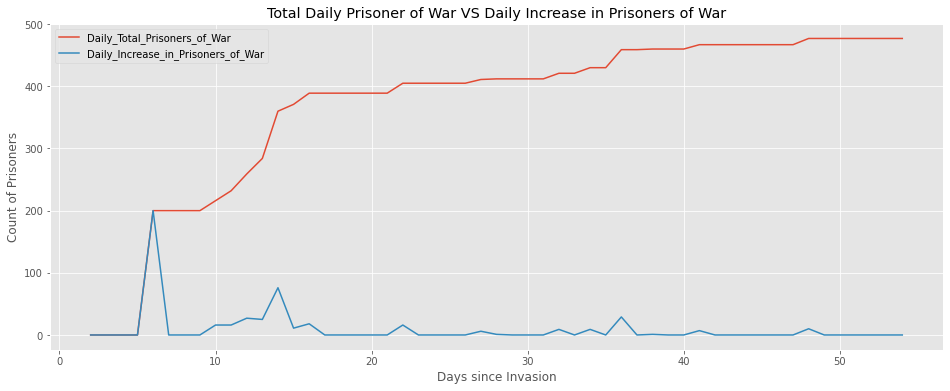

In [11]:
pow_data_.plot(kind='line', figsize=(16,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS Daily Increase in Prisoners of War")
plt.show()

### Problem 4

##### Visualize the daily change in POW

       Daily_Total_Prisoners_of_War  Daily_Increase_in_Prisoners_of_War
count                     53.000000                           53.000000
mean                     368.830189                            9.000000
std                      134.542206                           29.495762
min                        0.000000                            0.000000
25%                      371.000000                            0.000000
50%                      412.000000                            0.000000
75%                      467.000000                            7.000000
max                      477.000000                          200.000000


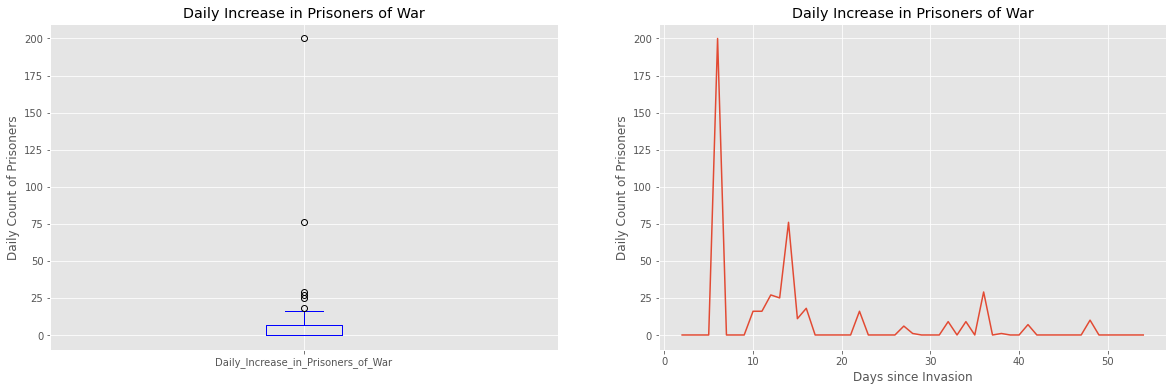

In [12]:
print(pow_data_.describe())

fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Subplot 1: Box plot
pow_data_['Daily_Increase_in_Prisoners_of_War'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax0) 
ax0.set_title('Daily Increase in Prisoners of War')
ax0.set_ylabel('Daily Count of Prisoners')

# # Subplot 2: Line plot
pow_data_['Daily_Increase_in_Prisoners_of_War'].plot(kind='line', figsize=(20,6), ax=ax1)
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title("Daily Increase in Prisoners of War")

plt.show()

### Problem 5

##### What Is the total daily loss for all equipment? Show all equipment types.


In [13]:
daily_total_equip_loss = pd.DataFrame(russian_equipment.reset_index('date'))
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)
daily_total_equip_loss['DailyTotal'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss


,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,DailyTotal
day,,,,,,,,,,,,,,
2,10,7,80,516,49,4,100,60,0,2,0,0,0,828
3,27,26,146,706,49,4,130,60,2,2,0,0,0,1152
4,27,26,150,706,50,4,130,60,2,2,0,0,0,1157
5,29,29,150,816,74,21,291,60,3,2,5,0,0,1480
6,29,29,198,846,77,24,305,60,3,2,7,0,0,1580
7,30,31,211,862,85,40,355,60,3,2,9,0,0,1688
8,30,31,217,900,90,42,374,60,3,2,11,0,0,1760
9,33,37,251,939,105,50,404,60,3,2,18,0,0,1902
10,39,40,269,945,105,50,409,60,3,2,19,0,0,1941


### Problem 6

##### How much equipment did Russia lose in the first 5 days of the invasion?

In [14]:
daily_total_equip_loss.head(4)

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,DailyTotal
day,,,,,,,,,,,,,,
2,10,7,80,516,49,4,100,60,0,2,0,0,0,828
3,27,26,146,706,49,4,130,60,2,2,0,0,0,1152
4,27,26,150,706,50,4,130,60,2,2,0,0,0,1157
5,29,29,150,816,74,21,291,60,3,2,5,0,0,1480


### Problem 7

##### What is the most recent count of equipment loss?

In [15]:
daily_total_equip_loss.tail()

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,DailyTotal
day,,,,,,,,,,,,,,
50,160,144,753,1968,366,122,1437,76,134,7,64,25,4,5260
51,163,144,756,1976,366,122,1443,76,135,8,66,25,4,5284
52,163,145,762,1982,371,125,1458,76,138,8,66,26,4,5324
53,165,146,773,2002,376,127,1471,76,148,8,66,27,4,5389
54,167,147,790,2041,381,130,1487,76,155,8,67,27,4,5480


### Problem 8

##### Is there any correlation between the POW and equipment loss?


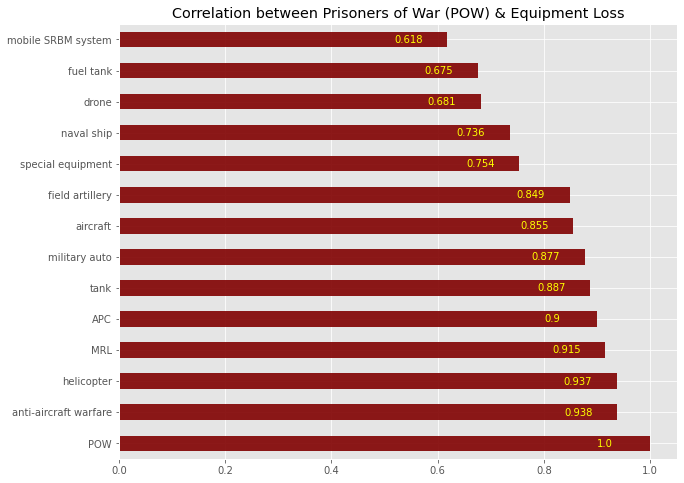

In [16]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(10,8),alpha=.9,color='maroon')
for index, value in enumerate(merged):
    value = round_sig(value)
    label = format(value)
    plt.annotate(label, xy=(value-.1, index-.1), color='yellow')

### Problem 9

##### What inferences can you make from the relationship between POW and Equipment loss?


In [17]:
print(f"There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from {round_sig(merged.values[1])} ({merged.keys()[1]}) to {round_sig(merged.values[-1])} ({merged.keys()[-1]}). The median correlation is {round_sig(merged.describe()[-3])} and it falls between {merged.keys()[6]} and {merged.keys()[7]}. The standard deviation is {round_sig(merged.describe()[2])} which indicated that the there is not much variability in the data; all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of {merged.keys()[1]} by at least {round_sig(merged.describe()[3])}.")


There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from 0.938 (anti-aircraft warfare) to 0.618 (mobile SRBM system). The median correlation is 0.866 and it falls between military auto and aircraft. The standard deviation is 0.117 which indicated that the there is not much variability in the data; all points are close to the mean. It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of anti-aircraft warfare by at least 0.618.


<!-- It should be noted that the strongest correlation exists not between the equipmet type with the highest loss({}) but with the type that had the ({}) highest loss. -->